# Example-17: FMA-FB

In [1]:
# FMA-FB combines REM and FMA indicators

In [2]:
# Import

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# Indicators

from tohubohu import rem
from tohubohu import exponential
from tohubohu import fma
from tohubohu import fma_fb

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set initial grid

n = 2001

qs = jax.numpy.linspace(-1.0, 1.0, n)
ps = jax.numpy.linspace(-1.0, 1.0, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
xs.shape

(4004001, 2)

In [6]:
# Set indicators

length = 2**10

level = 1.0E-16
knobs = jax.numpy.array([-0.8375, 0.00])

fn_rem = jit(rem(length, forward2D, inverse2D, epsilon=1.0E-16))
fn_fma = jit(fma(2**1, exponential(length), forward2D))
fn_fma_fb = jit(fma_fb(exponential(length), forward2D, inverse2D, epsilon=1.0E-16))

@jit
def indicator_rem(x):
    return jax.numpy.log10(level + fn_rem(x, knobs))

@jit
def indicator_fma(x):
    return jax.numpy.log10(level + jax.numpy.sqrt(jax.numpy.sum(jax.numpy.diff(fn_fma(x, knobs).T)**2)))

@jit
def indicator_fma_fb(x):
    x_return, f_forward, f_inverse = fn_fma_fb(x, knobs)
    error = jax.numpy.log10(level + jax.numpy.linalg.norm(x - x_return))
    delta = jax.numpy.log10(level + jax.numpy.abs(f_forward + f_inverse - 1).squeeze())
    return jax.numpy.stack([error, delta])

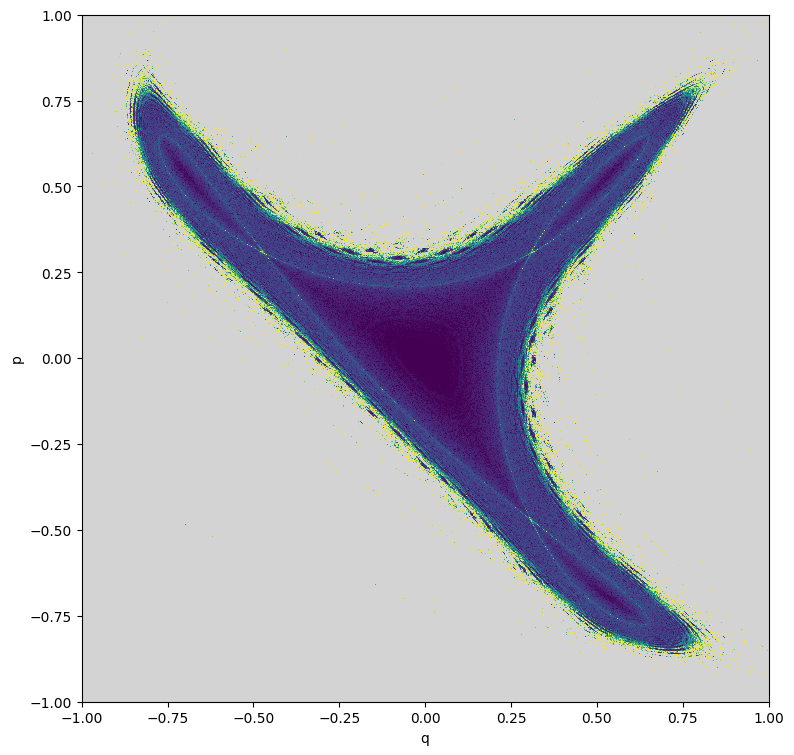

In [7]:
# Evaluate indicator (REM)

out = jit(vmap(indicator_rem))(xs).block_until_ready()

# Winsorize data

data = numpy.array(out)
data[data < -15.0] = -15.0
data[data > -3.0] = -3.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=-3.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()

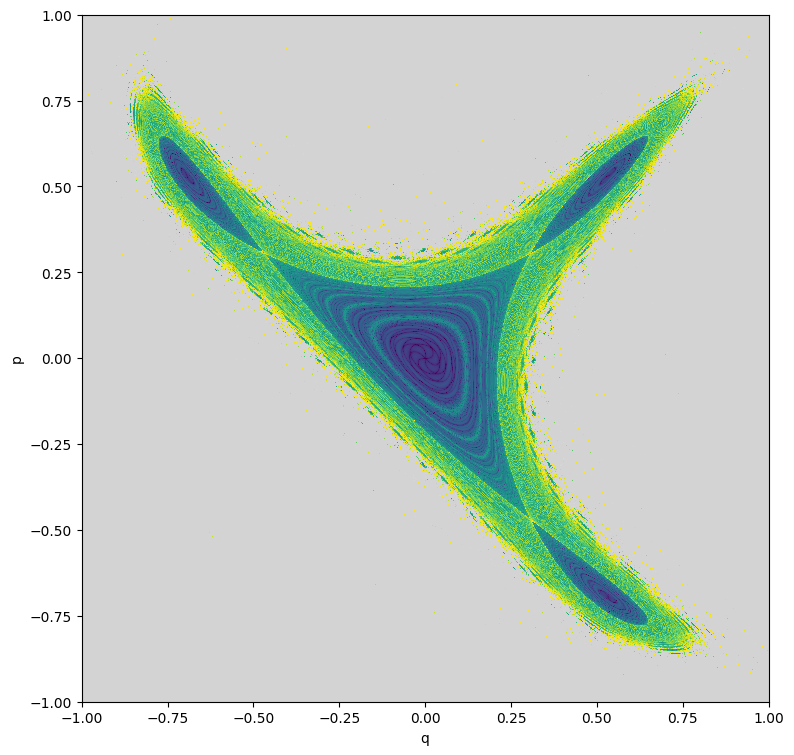

In [8]:
# Evaluate indicator (FMA)

out = jit(vmap(indicator_fma))(xs).block_until_ready()

# Winsorize data

data = numpy.array(out)
data[data < -15.0] = -15.0
data[data > -3.0] = -3.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=-3.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()

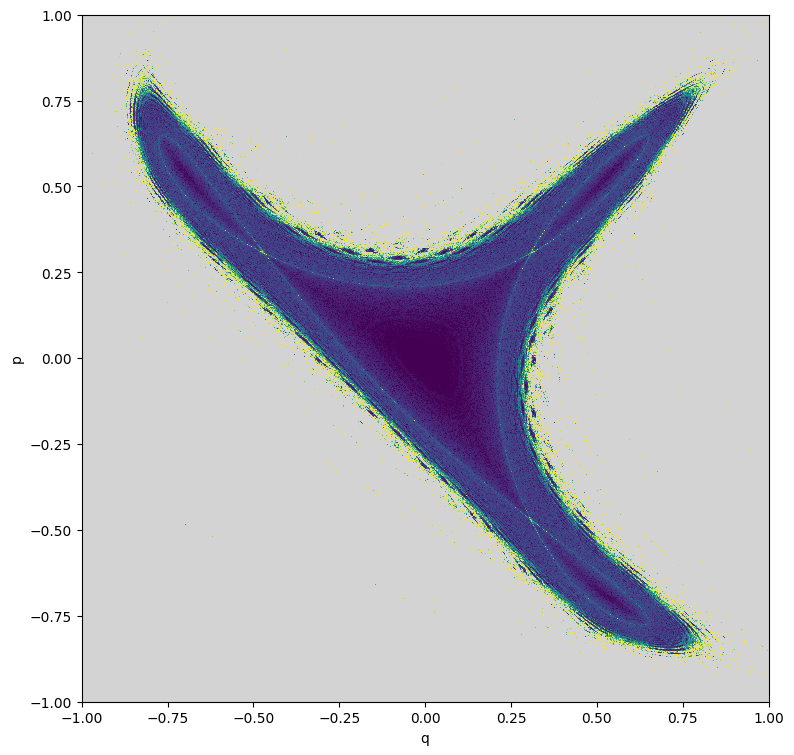

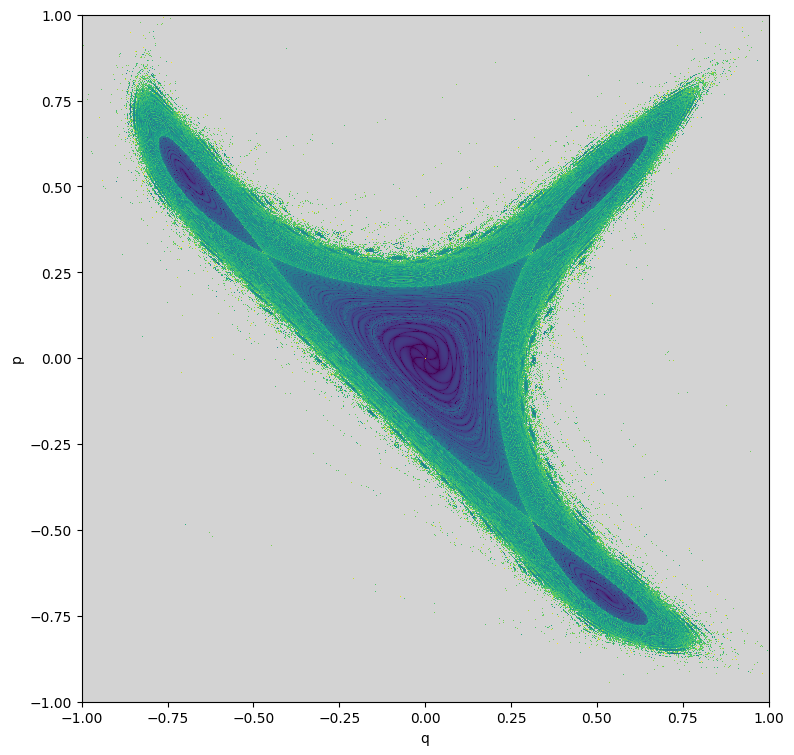

In [9]:
# Evaluate indicator (FMA-FB)

out_a, out_b = jit(vmap(indicator_fma_fb))(xs).T.block_until_ready()

# Winsorize data

data = numpy.array(out_a)
data[data < -15.0] = -15.0
data[data > -3.0] = -3.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=-3.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()

# Winsorize data

data = numpy.array(out_b)
data[data < -15.0] = -15.0
data[data > -3.0] = -3.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=-3.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()